In [1]:
import sys


# add workspace root directory to Python path for local imports
workspace_root = '/home/workspace'
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from scripts.plots import *
from scripts.utils import *

In [2]:
ARCHITECTURE_CHOICE = 'simple_w_temp_stages'
SUB_ARCHITECTURES = ['AQFP', 'AQFP_chip2chip_pipeline']
IGNORE_LAYERS = ['144']

WORKLOAD_CHOICE = 'gpt2_medium'
BATCH_SIZE = 8

if not SUB_ARCHITECTURES:
    SUB_ARCHITECTURES = [os.path.basename(f).rsplit('.', 1)[0] for f in glob.glob(f'../models/architectures/{ARCHITECTURE_CHOICE}/*.yaml')]

print(f'Architecture: {ARCHITECTURE_CHOICE} {", ".join(SUB_ARCHITECTURES)}')
print(f'Workload: {WORKLOAD_CHOICE}')

Architecture: simple_w_temp_stages AQFP, AQFP_chip2chip_pipeline
Workload: gpt2_medium


In [3]:
def test_full_dnn(
    dnn_name,
    return_per_layer=False,
    fail_ok=False,
    **kwargs
):
    # Many of the layerse have the same shape, so this code runs each unique shape once
    # and then copies the result for the other layers with the same shape.
    all_yamls = sorted(os.listdir(f"../models/workloads/{dnn_name}"))
    all_yamls = [f for f in all_yamls if f.endswith('.yaml')]
    all_yamls = [y for y in all_yamls if f"{y}.yaml" not in IGNORE_LAYERS]
    yaml2content = {}
    for yaml in all_yamls:
        with open(f"../models/workloads/{dnn_name}/{yaml}", 'r') as f:
            yaml2content[yaml] = f.read()
    content2yamls = {}
    for yaml, content in yaml2content.items():
        content2yamls.setdefault(content, []).append(yaml)
        
    results = parallel(
        delayed(generate_result)(
            layer=yamls[0],
            return_none_on_fail=fail_ok,
            **kwargs
        )
        for yamls in content2yamls.values()
    )
    
    yaml2result = {}
    for yamls, result in zip(content2yamls.values(), results):
        for yaml in yamls:
            if result is None:
                print(f'{yaml} failed')
            else:
                yaml2result[yaml] = result
            
    yaml2result_sorted = {
        yaml: yaml2result[yaml] for yaml in all_yamls if yaml in yaml2result
    }
            
    if return_per_layer:
        return yaml2result_sorted
    result = tl.OutputStats.aggregate(list(yaml2result_sorted.values()))
    print(f'Total computes: {result.computes}')
    return result


kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    n_macs=1,
    reg_depth=128,
    reg_width=16,
    batch_size=BATCH_SIZE,
)

results = {}
for sub_architecture in SUB_ARCHITECTURES:
    results[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        fail_ok=True,
        **kwargs
    )

results_wo_cooling = {}
for sub_architecture in SUB_ARCHITECTURES:
    results_wo_cooling[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        add_cooling=False,
        fail_ok=True,
        **kwargs
    )
energy_per_compute_wo_cooling = {k:v.per_compute('per_component_energy') for k,v in results_wo_cooling.items()}
area_wo_cooling = {k:v.per_component_area for k, v in results_wo_cooling.items()}

results_w_cooling = {}
for sub_architecture in SUB_ARCHITECTURES:
    results_w_cooling[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        add_cooling=True,
        fail_ok=True,
        **kwargs
    )
energy_per_compute_w_cooling = {k:v.per_compute('per_component_energy') for k,v in results_w_cooling.items()}
area_w_cooling = {k:v.per_component_area for k,v in results_w_cooling.items()}


100%|██████████| 7/7 [00:00<00:00, 894.66it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 9471.01it/s]


Failed to generate result for sub_architecture: AQFP_chip2chip_pipeline
144.yaml failed
Total computes: 618726948864


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 18407.60it/s]


Failed to generate result for sub_architecture: AQFP_chip2chip_pipeline
144.yaml failed
Total computes: 618726948864


100%|██████████| 7/7 [00:00<00:00, 16275.02it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 17718.85it/s]


Failed to generate result for sub_architecture: AQFP_chip2chip_pipeline
144.yaml failed
Total computes: 618726948864


(1e-19, 5e-10)

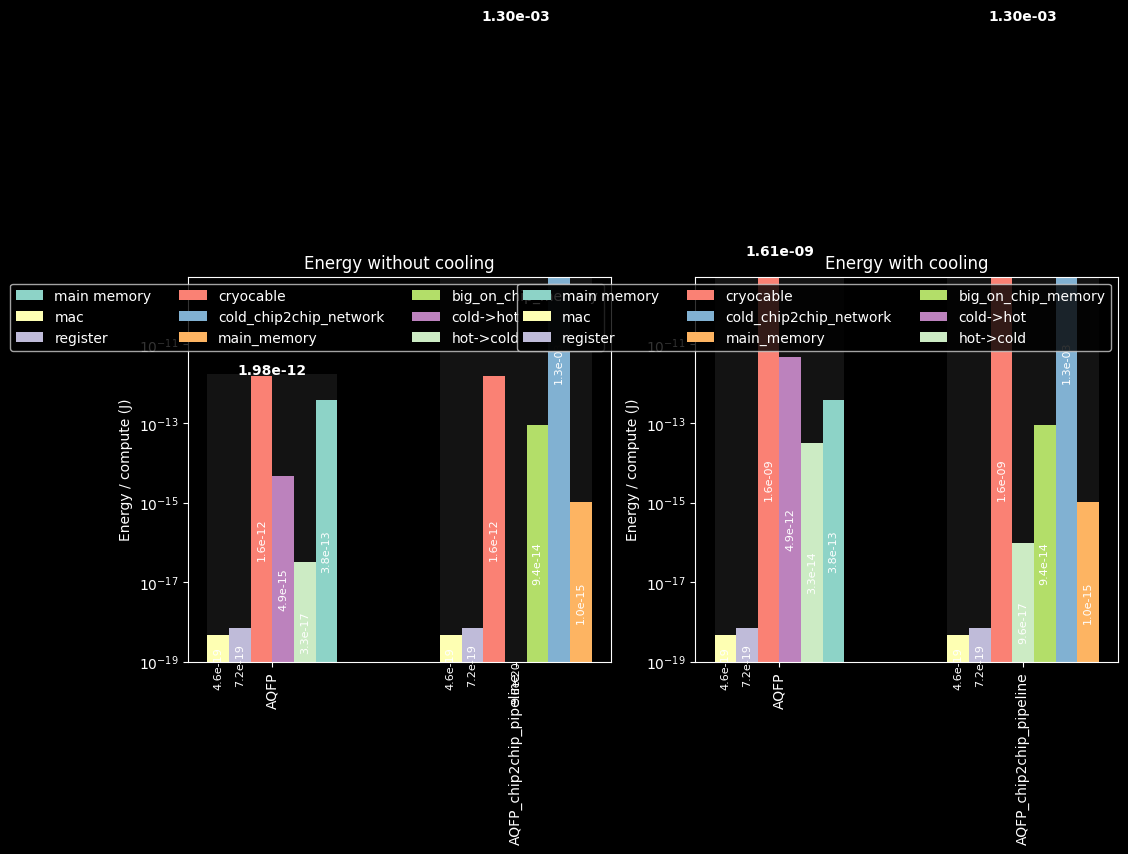

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute_wo_cooling, ylabel="Energy / compute (J)", title="Energy without cooling", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(energy_per_compute_w_cooling, ylabel="Energy / compute (J)", title="Energy with cooling", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)

axs[1].set_ylim(bottom=1e-19, top=5e-10)
axs[0].set_ylim(bottom=1e-19, top=5e-10)

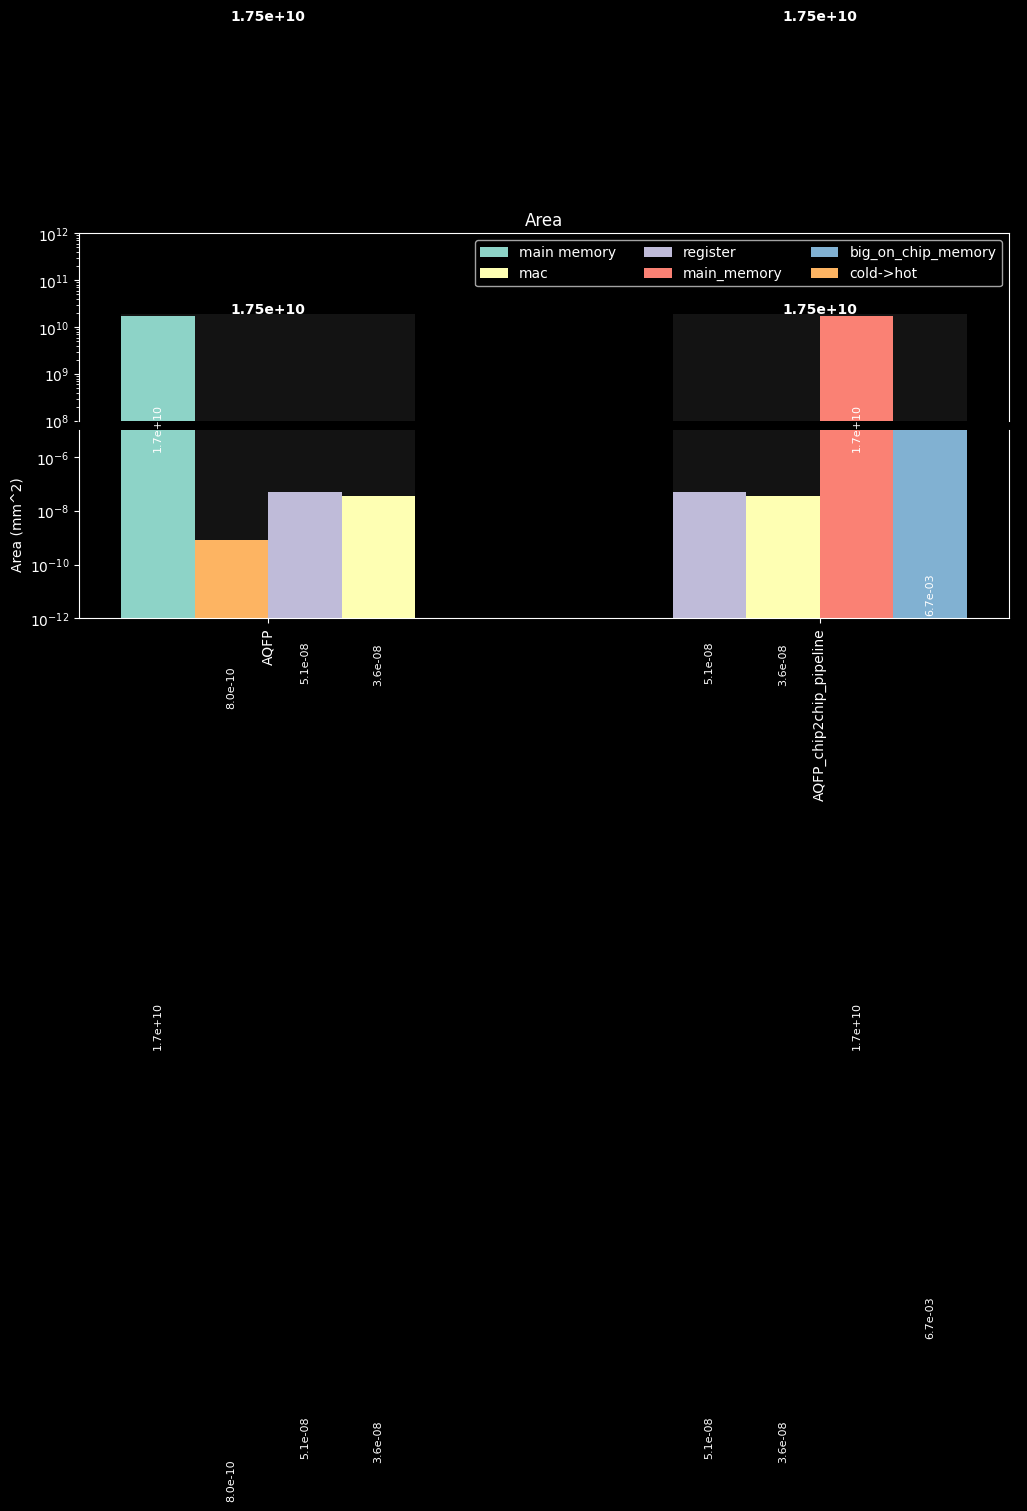

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
fig.subplots_adjust(hspace=0.05)

bar_side_by_side(area_w_cooling, title="Area", yscale="log", missing_ok=True, ax=ax1, legend_ncol=3)
bar_side_by_side(area_w_cooling, ylabel="Area (mm^2)", yscale="log", missing_ok=True, ax=ax2, legend_off = True)

ax1.set_ylim(1e8, 1e12)
ax2.set_ylim(1e-12, 1e-5)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(bottom=False)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

## Small register and single MAC

In [6]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=1,
    reg_depth=128,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, add_cooling=False, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}

NameError: name 'LAYER_CHOICE' is not defined

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)

## Larger register and single MAC

In [8]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=1,
    reg_depth=128*4,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, add_cooling=False, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)

## Large register and many MACs

In [10]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    layer=LAYER_CHOICE,
    n_macs=16,
    reg_depth=128*4,
    reg_width=16
)

results = {}
results = Parallel(n_jobs=-1)(delayed(generate_result)(sub_architecture, BATCH_SIZE, add_cooling=False, **kwargs) for sub_architecture in SUB_ARCHITECTURES)
results = {sub_architecture: result for sub_architecture, result in zip(SUB_ARCHITECTURES, results)}
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy Performance", yscale="log", ax=axs[0], legend_ncol=3, missing_ok=True)
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area Performance", yscale="log", ax=axs[1], legend_ncol=3, missing_ok=True)